___

In [1]:
# Imports
import pandas as pd

___
**_Bitte beachten:_**

- In Code-Zellen soll (bei Bedarf kommentierter) Code eingefügt werden. In Raw-Zellen erwarten wir Antworten im Freitext-Format.
- Fragestellungen sind teilweise bewusst etwas offener formuliert, weil Sie auch im Arbeitsleben nur selten mit ganz spezifischen Anweisungen rechnen können.Es gibt häufig mehrere mögliche Lösungen, dies wird in der Korrektur  berücksichtigt.

___

# (I can't get no) satisfaction
Wir arbeiten weiterhin mit dem Datensatz über die Zufriedenheit von Angestellten der fiktiven Firma *Fiktiva*. In dieser Kurseinheit werden wir einige Techniken zur Datenvorverarbeitung / zum Data Cleaning anwenden.

Sie können hier, wenn Sie weitere Informationen benötigen, ebenfalls externe Quellen verwenden und bspw. die Datei `metadata.txt` zu Rate ziehen, aber auch alle Informationen aus dem Fiktiva-Newsletter. 

In [2]:
# Datensatz laden
# Hinweis: Laden Sie den Datensatz so, dass die erste Spalte als Index (Row Label) verwendet wird
df = pd.read_csv("../data/employees_satisfaction.csv", index_col=0)

***Hinweis zur Korrektur:*** *Die Lösung ist nur mit der Angabe von `index_col=0` als korrekt zu bewerten.*

## Spalten umbennen

Die Spalte `Dept` wird als einzige groß geschrieben. Benennen Sie die Spalte deshalb in `department` um.

In [3]:
# Ihre Lösung
df.rename(columns = {"Dept":"department"}, inplace = True)

***Hinweis zur Korrektur:*** *Es muss nicht zwingend `inplace=True` verwendet werden, eine Angabe ähnlich zu `df = df.rename(...)` ist ebenfalls valide.*

## Spalten transformieren
Um ein besseres Gefühl für die Werte der Spalte `salary` zu bekommen, wandeln wir die Werte, die aktuell in US-Dollar angegeben sind, in Euro um. Aktualisieren Sie anschließend auch die Datei `metadata.txt`.

*Hinweis: Verwenden Sie folgenden Umrechnungskurs: $ 1\$ = 0.9€ $*

In [4]:
# Ihre Lösung
df["salary"] = df["salary"]*0.9

Die Spalte `entry_date` enthält Informationen über das Einstellungsdatum, die Daten sind jedoch nicht vom Typ Datetime. Dies ist für Datums-Berechnungen sehr ungünstig, wandeln Sie den Datentypen deshalb entsprechend um.

In [5]:
# Ihre Lösung
df["entry_date"] = pd.to_datetime(df["entry_date"], format="%Y-%m-%d")

In der Spalte `gender` sind die Werte nicht einheitlich kodiert (`m`/`Male` und `f`/`Female`). Vereinheitlichen Sie diese Spalte, so dass `m` zu `Male` wird und `f` zu `Female`. Dazu können Sie untenstehendes Dictionary `gender_recoding` verwenden.

In [6]:
gender_recoding = {
    "f": "Female",
    "m": "Male"
}

In [7]:
# Ihre Lösung
df["gender"] = df["gender"].replace(gender_recoding)

***Hinweis zur Korrektur:*** *Eine Verwendung von `map()` oder ähnlichen Methoden ist ebenfalls valide. Es muss jedoch darauf geachtet werden, dass die Zeilen, in denen bereits `Male` oder `Female` steht, nicht geändert werden.*

In der Spalte `education` ist der Ausbildungsgrad der Angestellten in `UG`/`PG` angegeben:

In [8]:
df["education"].unique()

array(['PG', 'UG'], dtype=object)

Dies sind in Deutschland keine gebräuchlichen Abkürzungen, weshalb die Information u.U. nicht verständlich ist. Transformieren Sie die Spalte, so dass die Abkürzungen ausgeschrieben und somit verständlicher sind. Aktualisieren Sie außerdem die Datei `metadata.txt` und fügen Sie eine kurze Erklärung zu den beiden Ausprägungen hinzu.

In [9]:
# Ihre Lösung
education_recoding = {
    "UG": "Undergraduate",
    "PG": "Postgraduate"
}
df["education"] = df["education"].map(education_recoding)

## Plausibilitätschecks
Es ist sinnvoll, einige Prüfungen bzgl. der Plausibilität der Daten vorzunhemen.

Nehmen Sie an, einer Ihrer Plausibilitätschecks schlägt fehlt. Was sollten Sie dann tun?

Wir würden davon ausgehen, dass Personen frühestens ab 16 Jahren fest in einer Firma angestellt werden. Prüfen Sie deshalb, ob alle Personen mindestens 16 Jahre alt waren, als Sie bei der Firma begonnen haben (siehe `entry_date`). Gehen Sie dafür davon aus, dass der Datensatz am 01.01.2021 erstellt wurde (siehe Variable `created`).

In [10]:
from datetime import date
created = date(2021, 1, 1)

In [11]:
# Ihre Lösung
df.where(~((df["age"] - (created.year - df["entry_date"].dt.year) > 15))).dropna()

,emp_id,age,department,education,recruitment_type,job_level,rating,awards,certifications,salary,gender,entry_date,last_raise,satisfied


***Hinweis zur Korrektur:*** *Unterschiedliche Lösungswege sind möglich, wichtig ist, dass der Check erfolgreich ist und zeigt, dass es keine Personen gibt, die zum Einstellungsdatum jünger als 16 Jahre alt waren und der Datensatz deshalb in diesem Bezug nicht weiter bereinigt werden muss.*

Die ID der Angestellten scheint mit ihrer Abteilung zusammenzuhängen. Betrachten wir bspw. den ersten Datensatz:

In [12]:
df.loc[1][["emp_id", "department"]]

emp_id          TECH1860
department    Technology
Name: 1, dtype: object

Die ersten Buchstaben beziehen sich auf die Abteilung. Wir gruppieren das Dataframe und schauen uns aus jeder Abteilung die `emp_id` des ersten Datensatzes an.

In [13]:
df.groupby("department").first()["emp_id"]

department
HR              HR8270
Marketing      MKT2685
Purchasing     PUR7265
Sales          SAL6191
Technology    TECH1860
Name: emp_id, dtype: object

Wir gehen deshalb von folgender Zuordnung aus:

In [14]:
id_dept_mapping = {
    "HR":"HR",
    "MKT":"Marketing",
    "PUR":"Purchasing",
    "SAL":"Sales",
    "TECH":"Technology"

}

Den Buchstaben folgt dann immer eine eindeutige Nummer, der Aufbau ist also \<dept_id\>\<employee_number\>.

Wir wollen prüfen, ob dieses Muster für alle Angestellten konsistent ist. Dafür verwenden wir die Funktion `check_id`. Diese prüft mittels des oben angegebenen Dictionary `id_dept_mapping`, ob `dept_id` und die Abteilung zusammenpassen. Zur Extraktion der `dept_id` sollen Sie einen regulären Ausdruck erstellen. Prüfen Sie anschließend mithilfe der Funktion `check_id`, ob das Muster für alle Angestellten konsistent ist.

*Hinweis: Sie können vom obigen Aufbau ausgehen, bei dem `dept_id` immer aus Buchstaben besteht, während `employee_number` immer Zahlen sein sollen.*

In [15]:
import re
# Ihre Lösung
regular_expression = "[A-Z]+" # <- fügen Sie hier den entsprechenden regulären Ausdruck ein

In [16]:
def check_id(emp_id, department):
    dept_id = "".join(re.findall(regular_expression, emp_id))
    return id_dept_mapping.get(dept_id) == department

In [17]:
# Ist der Check für alle Zeilen des Datensatzes erfolgreich?
df.apply(lambda x: check_id(x["emp_id"], x["department"]), axis=1).all()

True

***Hinweis zur Korrektur:*** *Auch hier sind unterschiedliche Lösungen möglich, der Check sollte jedoch in jedem Fall erfolgreich sein.*

## Fehlende Werte
Oft kommt es vor, dass in Daten Werte fehlen. Dies kann unterschiedlichste Gründe haben, z.B. kann ein Wert bewusst weggelassen werden (bpsw. der Titel in einer Anrede) oder Daten können nicht korrekt übertragen werden. Für viele Analysen ist es jedoch wichtig, dass es keine fehlenden Werte gibt.

Das Ersetzen von fehlenden Werten wird als *(Missing Value) Imputation* bezeichnet. Hierfür gibt es verschiedene Strategien:
- Korrekten Wert ermitteln: Im besten Fall kann der korrekte Wert ermittelt werden, bspw. durch Rücksprache mit (Fach-)Expert\*innen. Dies ist jedoch nur selten der Fall und häufig mit großem Aufwand verbunden.
- Zeilen mit fehlenden Werten löschen: Fehlen wenige, einzelne Werte, kann es u.U. sinnvoll sein, die entsprechenden Zeilen zu löschen. Hierbei muss jedoch darauf geachtet werden, dass nicht zu viele Informationen verloren gehen.
- Spalte mit fehlenden Werten löschen: Fehlen in einer Spalte so viele Werte, dass diese keine Aussagekraft mehr hat, kann es sinnvoll sein, die gesamte Spalte zu entfernen.
- Neuen Wert einsetzen:
    - Neue Kategorie: Bei nominalen Werten kann eine neue Kategorie (z.B. "Unbekannt") eingeführt werden.
    - Mode Imputation: Die fehlenden Werte werden durch den am häufigst vorkommenden Wert ersetzt.
    - Mean Imputation: Die fehlenden Werte werden durch den Mittelwert ersetzt.
    - Median Imputation: Die fehlenden Werte werden durch den Median ersetzt.
    - Mode, Mean und Median Imputation können auch basierend auf den Werten einer anderen Spalte vorgenommen werden (in unserem Fall z.B. für zufriedene und unzufriedene Angestellte getrennt).
    - Imputation mit 0 oder einem anderen konstanten Wert: Die fehlenden Werte werden durch eine 0 oder eine andere, je nach Anwendungsfall passende, Konstante ersetzt.
    - Modell-basierte Imputation: Es wird ein Machine-Learning-Modell trainiert, das die fehlenden Werte vorhersagt.
    - Zusätzlich zu den genannten Strategien ist es möglich, ein neues Feature zu erstellen, das kennzeichnet, ob eine Imputation vorgenommen wurde (=1) oder nicht (=0).

Wir bleiben bei der Spalte `gender`, hier gibt es fehlende Werte.

In [18]:
df["gender"].isna().sum()

3

Wählen Sie eine geeignete Strategie zur *Imputation*, also der Ersetzung der fehlenden Werte. Begründen Sie Ihre Entscheidung!

In [19]:
# Ihre Lösung
df["gender"] = df["gender"].fillna("Unknown")

***Hinweis zur Korrektur:*** *Wichtig ist hier vor allem eine gute Begründung für die gewählte Strategie. Eine Mode-Imputation wäre keine gute Lösung, da dies das Verhältnis verzerren kann.*

Auch in der Spalte `last_raise` gibt es fehlende Werte.

In [20]:
df["last_raise"].isna().sum()

474

Entscheiden Sie sich hier ebenfalls für eine geeignete Imputation-Strategie und begründen Sie Ihre Wahl.

In [21]:
# Ihre Analysen
df.sort_values(by="entry_date").head(50)

,emp_id,age,department,education,recruitment_type,job_level,rating,awards,certifications,salary,gender,entry_date,last_raise,satisfied
386,TECH8253,48,Technology,Undergraduate,Referral,5,5.0,4,1,78075.0,Male,2004-01-05,0.07,1
45,PUR8099,36,Purchasing,Undergraduate,On-Campus,5,5.0,4,0,78075.0,Female,2004-01-16,0.04,1
360,MKT1830,40,Marketing,Postgraduate,Walk-in,5,1.0,8,1,78075.0,Male,2004-01-20,0.08,0
161,MKT2636,34,Marketing,Postgraduate,On-Campus,2,2.0,8,0,26824.5,Female,2004-01-20,0.10,0
375,PUR4672,40,Purchasing,Postgraduate,Referral,2,3.0,2,1,26824.5,Male,2004-01-22,0.02,1
134,HR4627,44,HR,Undergraduate,Referral,2,4.0,8,0,26824.5,Male,2004-02-24,0.01,1
9,TECH9322,45,Technology,Postgraduate,Referral,3,3.0,9,0,38177.1,Female,2004-03-19,0.07,0
274,TECH4444,39,Technology,Undergraduate,On-Campus,2,3.0,3,1,26824.5,Female,2004-04-13,0.08,1
389,PUR3141,37,Purchasing,Postgraduate,Walk-in,2,5.0,8,1,26824.5,Female,2004-04-17,0.02,1
239,HR5433,38,HR,Undergraduate,On-Campus,3,3.0,3,1,38177.1,Male,2004-04-19,0.04,1


In [22]:
df[~df["last_raise"].isnull()]["entry_date"].max()

Timestamp('2004-10-30 00:00:00')

In [23]:
df[df["last_raise"].isnull()]["entry_date"].min()

Timestamp('2004-11-13 00:00:00')

In [24]:
df["entry_date"].quantile(0.05)

Timestamp('2004-10-30 00:00:00')

In [25]:
df["entry_date"].max()

Timestamp('2020-12-17 00:00:00')

In [26]:
# Ihre Lösung
df = df.drop("last_raise", axis=1)

***Hinweis zur Korrektur:*** *Da hier zu viele Werte fehlen, wäre eine Ersetzung der fehlenden Werte nicht sinnvoll.*

Eine weitere Spalte mit fehlenden Werten ist `rating`.

In [27]:
df["rating"].isna().sum()

29

Entscheiden Sie sich hier ebenfalls für eine geeignete Imputation-Strategie und begründen Sie Ihre Wahl.

In [28]:
# Ihre Analysen
df[df['rating'].isnull()]

,emp_id,age,department,education,recruitment_type,job_level,rating,awards,certifications,salary,gender,entry_date,satisfied
61,SAL8629,53,Sales,Postgraduate,Recruitment Agency,1,NaN,6,1,21668.4,Male,2020-11-26,1
67,HR8916,28,HR,Postgraduate,Referral,1,NaN,7,1,21668.4,Female,2020-09-10,0
69,HR1878,27,HR,Postgraduate,Walk-in,1,NaN,5,0,21668.4,Male,2020-06-01,1
70,HR5887,30,HR,Undergraduate,Recruitment Agency,1,NaN,0,0,21668.4,Female,2020-05-30,0
117,TECH3790,45,Technology,Undergraduate,On-Campus,5,NaN,4,0,78075.0,Male,2020-10-18,1
123,MKT8574,39,Marketing,Undergraduate,Recruitment Agency,5,NaN,3,1,78075.0,Male,2020-01-10,0
145,HR6530,49,HR,Undergraduate,Referral,2,NaN,9,1,26824.5,Male,2020-10-10,0
184,HR8777,44,HR,Undergraduate,On-Campus,5,NaN,3,0,78075.0,Male,2020-03-19,0
222,PUR8400,48,Purchasing,Postgraduate,Recruitment Agency,5,NaN,9,1,78075.0,Male,2020-05-14,1
236,TECH3200,45,Technology,Postgraduate,Referral,3,NaN,0,0,38177.1,Male,2020-04-06,1


In [29]:
# Ihre Lösung
df["rating"] = df["rating"].fillna("Unavailable")

***Hinweis zur Korrektur:*** *Auch hier ist die Begründung für die gewählte Strategie entscheidend. Es können auch Argumente dafür gefunden werden, statt "Unavailable" o.ä. die Imputation mit einem numerischen Wert vorzunehmen. Hier wäre z.B. der Median denkbar, der Mean hingegen wäre keine gute Strategie, da als Rating nur ganze Zahlen in Frage kommen.*

## Ausreißer

Betrachten wir die Histogramme für die Spalten `awards` und `certifications`:

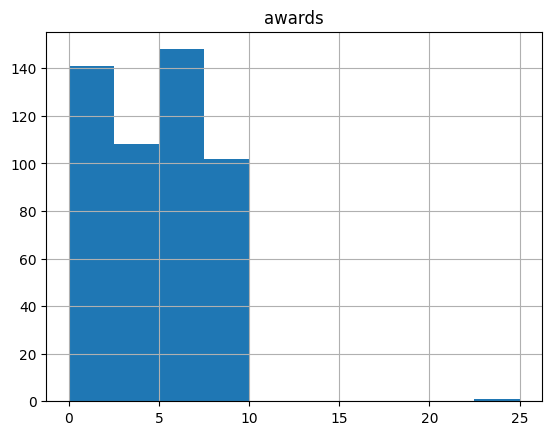

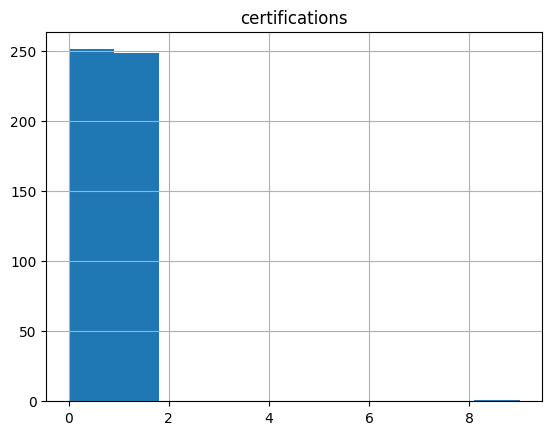

In [30]:
for col in ["awards", "certifications"]:
    df.hist(col)

In diesen beiden Spalten scheint es Ausreißer in Werten zu geben.

Betrachten wir zunächst die Spalte `awards`. Identifizieren Sie die Zeile, in der der Ausreißer vorkommt, und überlegen Sie sich eine geeignete Strategie, um mit diesem Wert umzugehen.

In [31]:
# Ihre Analysen
df["awards"].value_counts()

3     57
8     56
0     52
5     52
4     51
7     50
2     48
9     46
6     46
1     41
25     1
Name: awards, dtype: int64

In [32]:
df[df["awards"]==25]

,emp_id,age,department,education,recruitment_type,job_level,rating,awards,certifications,salary,gender,entry_date,satisfied
233,TECH3557,55,Technology,Undergraduate,Referral,5,1.0,25,0,78075.0,Female,2010-05-02,1


In [33]:
# Ihre Lösung
# keine Aktion notwendig

***Hinweis zur Korrektur:*** *Hier soll erkannt werden, dass der Wert valide ist und deshalb keine Aktion notwendig ist.*

Wenden wir uns nun der Spalte `certifications` zu. Identifizieren Sie auch hier den Ausreißer und überlegen Sie sich eine geeignete Strategie, um mit diesem Wert umzugehen.

In [34]:
# Ihre Analysen
df["certifications"].value_counts()

0    251
1    248
9      1
Name: certifications, dtype: int64

In [35]:
df[df["certifications"]==9]

,emp_id,age,department,education,recruitment_type,job_level,rating,awards,certifications,salary,gender,entry_date,satisfied
129,HR2059,42,HR,Postgraduate,Referral,4,1.0,2,9,59143.5,Female,2014-04-09,1


In [36]:
# Ihre Lösung
idx = df[df["certifications"]==9].index
df.loc[idx, "certifications"] = 0

***Hinweis zur Korrektur:*** *Wie beschrieben sind unterschiedliche Lösungen denkbar, die Begründung ist entscheidend. Es sollte jedoch auch hier keine Mean-Imputation gewählt werden. Es sind nur Lösungen als korrekt zu bewerten, bei denen der Wert als Ergebnis entweder gelöscht oder durch 0 oder 1 ersetzt wurde (und gut begründet wurde).*

## Spalten/Zeilen löschen

Betrachten wir die Spalte `emp_id`. Aus wie vielen einzigartigen Werten besteht diese?

In [37]:
# Ihre Lösung
df["emp_id"].nunique()

499

Scheinbar gibt es eine ID doppelt. Schauen wir uns zunächst die Zeilen an, die die gleiche `emp_id` besitzen. Identifizieren Sie hierzu, um welche ID es sich handelt und lassen Sie sich dann die zugehörigen Zeilen ausgeben.

In [38]:
# Ihre Lösung
count_empid = df.groupby("emp_id").count().sort_values("age", ascending=False).iloc[:, 0]
df.where(df["emp_id"].isin(list(count_empid[count_empid > 1].index))).dropna(how="all")

,emp_id,age,department,education,recruitment_type,job_level,rating,awards,certifications,salary,gender,entry_date,satisfied
188,MKT7287,41.0,Marketing,Undergraduate,Referral,2.0,5.0,0.0,1.0,26824.5,Female,2014-04-07,1.0
215,MKT7287,50.0,Marketing,Postgraduate,Referral,2.0,2.0,1.0,0.0,26824.5,Male,2013-08-01,0.0


In [39]:
# Alternative Lösung
emp_id_duplicate = df["emp_id"].value_counts()[df["emp_id"].value_counts()>1].index[0]
df.where(df["emp_id"] == emp_id_duplicate).dropna(how="all")

,emp_id,age,department,education,recruitment_type,job_level,rating,awards,certifications,salary,gender,entry_date,satisfied
188,MKT7287,41.0,Marketing,Undergraduate,Referral,2.0,5.0,0.0,1.0,26824.5,Female,2014-04-07,1.0
215,MKT7287,50.0,Marketing,Postgraduate,Referral,2.0,2.0,1.0,0.0,26824.5,Male,2013-08-01,0.0


In [40]:
# Alternative Lösung
# ID ermitteln
print(df["emp_id"].value_counts())
# und händisch eintragen
df.where(df["emp_id"] == "MKT7287").dropna(how="all")

MKT7287     2
SAL6919     1
MKT6691     1
PUR4124     1
PUR3491     1
           ..
MKT2636     1
MKT8280     1
TECH8554    1
TECH4581    1
TECH7731    1
Name: emp_id, Length: 499, dtype: int64


,emp_id,age,department,education,recruitment_type,job_level,rating,awards,certifications,salary,gender,entry_date,satisfied
188,MKT7287,41.0,Marketing,Undergraduate,Referral,2.0,5.0,0.0,1.0,26824.5,Female,2014-04-07,1.0
215,MKT7287,50.0,Marketing,Postgraduate,Referral,2.0,2.0,1.0,0.0,26824.5,Male,2013-08-01,0.0


Wählen Sie eine geeignete Strategie, um mit diesem Duplikat umzugehen. Begründen Sie Ihre Entscheidung.

In [41]:
# Ihre Lösung
df = df.drop_duplicates(keep=False, subset=["emp_id"])

***Hinweis zur Korrektur:*** *Man könnte alternativ auch argumentieren, dass die Zeilen zu unterschiedlich sind, um als Duplikat gewertet zu werden und beide behalten werden. In dem Fall muss jedoch eine gute Strategie gefunden werden, um eine neue ID zu vergeben.*

Betrachten wir nun die Werte der Spalte `emp_id`. Bringen diese Informationen einen Mehrwert zu der Vorhersage der Zufriedenheit? Wenn ja, bleibt die Spalte im Datensatz, wenn nein, transformieren Sie den Datensatz entsprechend.

In [42]:
# Ihre Lösung
df = df.drop("emp_id", axis=1)

## Daten speichern

In [43]:
df

,age,department,education,recruitment_type,job_level,rating,awards,certifications,salary,gender,entry_date,satisfied
0,28,HR,Postgraduate,Referral,5,2.0,1,0,78075.0,Male,2019-02-01,1
1,50,Technology,Postgraduate,Recruitment Agency,3,5.0,2,1,38177.1,Male,2017-01-17,0
2,43,Technology,Undergraduate,Referral,4,1.0,2,0,59143.5,Female,2012-08-27,1
3,44,Sales,Postgraduate,On-Campus,2,3.0,0,0,26824.5,Female,2017-07-25,1
4,33,HR,Undergraduate,Recruitment Agency,2,1.0,5,0,26824.5,Male,2019-05-17,1
...,...,...,...,...,...,...,...,...,...,...,...,...
495,49,HR,Postgraduate,On-Campus,2,5.0,6,0,26824.5,Male,2014-03-21,1
496,24,Technology,Undergraduate,Referral,2,4.0,2,0,26824.5,Female,2018-02-20,0
497,34,Marketing,Postgraduate,On-Campus,1,Unavailable,2,0,21668.4,Male,2020-10-20,1
498,26,Technology,Undergraduate,Walk-in,2,1.0,1,1,26824.5,Male,2012-05-18,0


Wenn, Sie alle Aufgaben korrekt ausgeführt haben, ist die Vorverarbeitung nun abgeschlossen:
- Alle Spalten liegen im passenden Datenformat vor
- Kategorielle Spalten wurden vereinheitlicht
- Es gibt keine Duplikate
- Es gibt keine fehlenden Werte
- Die Plausibilitätschecks wurden bestanden

Speichern Sie den von Ihnen transformierten Datensatz unter dem Namen `employees_satisfaction_transformed.csv` ab.

In [44]:
# Ihre Lösung
df.to_csv("../data/employees_satisfaction_transformed.csv")